In [1]:
# Source: https://projects.volkamerlab.org/teachopencadd/talktorials/T009_compound_ensemble_pharmacophores.html

In [2]:
import collections
from collections import Counter
from pathlib import Path
import operator
import time
import math

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, cluster

from rdkit import RDConfig, Chem, Geometry, DistanceGeometry
from rdkit.Chem import (
    ChemicalFeatures,
    rdDistGeom,
    Draw,
    rdMolTransforms,
    AllChem,
)

from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.Numerics import rdAlignment
import nglview as nv

In [3]:
HERE = Path(_dh[-1])
DATA = HERE / 'data'

#### Retrive pre-aligned ligands from PDB_BACE.ipynb

In [4]:
mol_files = sorted(Path(HERE / '../capstone/data/').glob('*_lig.pdb'))
print([f.name for f in mol_files])

['3VF3_lig.pdb', '4B78_lig.pdb', '4L7G_lig.pdb', '6EJ2_lig.pdb', '6EQM_lig.pdb']


In [5]:
pdb_ids = [Path(file).stem.split('_')[0] for file in mol_files]
pdb_ids

['3VF3', '4B78', '4L7G', '6EJ2', '6EQM']

#### Read ligands from PDB files using rdkit

In [6]:
molecules = []
for mol_file in mol_files:
    molecule = Chem.MolFromPDBFile(str(mol_file), removeHs=False)
    if molecule is None:
        print(mol_file, 'Could not be read')
    else:
        Chem.SanitizeMol(molecule)
        print(Chem.MolToSmiles(molecule))
        molecules.append(molecule)
print(f"Number of molecules: {len(molecules)}")

CC(F)(F)C1CCCC(CNC2CS(O)(O)CC(CC3CC(F)C(N)C(Br)C3)C2O)C1
COC1CCC(C2(C3CCCC(C4CCCNC4)C3)CC(OC)C(N)N2)CC1
NC1NC2(C3CCCC(C4CNCNC4)C3)CCOCC2O1
[H]C1(C)CC2(CCC1([H])OC)CC1CCC(C3CNCNC3)CC1C21COC(N)N1
CC1CC(C(F)(F)F)CNC1C(O)NC1CCC(F)C(C2(C)COC(C)(C(F)(F)F)C(N)N2)N1
Number of molecules: 5


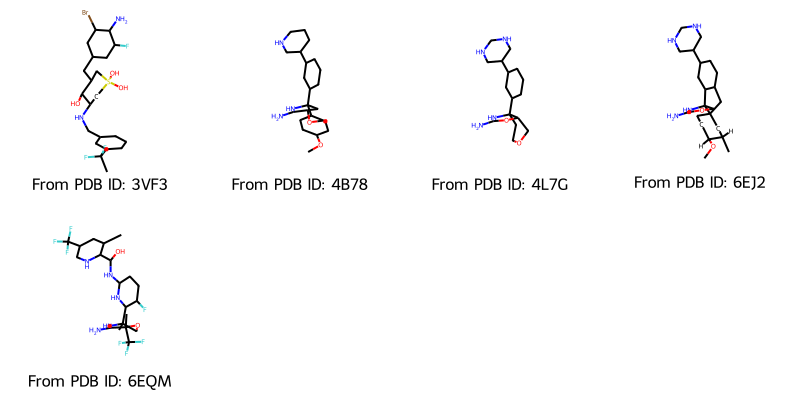

In [7]:
Draw.MolsToGridImage(
    molecules,
    molsPerRow=4,
    legends=[f"From PDB ID: {pdb_id}" for pdb_id in pdb_ids],
)

#### Correct the mistakes in aromatic rings

In [8]:
# Load SMILES for PDB ligand structures
ligands = pd.read_csv(HERE / '../capstone/data/BACE_top_ligands.csv')

# Get SMILES in the same order as in pdb_ids
ligand_smiles = [
    ligands[ligands['@structureId'] == pdb_id]['smiles'].values[0] for pdb_id in pdb_ids
]

# Generate RDKit Mol object from SMILES
reference_molecules = [Chem.MolFromSmiles(smiles) for smiles in ligand_smiles]

# Assign bond orders to molecules based on SMILES patterns of reference molecules
molecules = [
    AllChem.AssignBondOrdersFromTemplate(reference_molecule, molecule)
    for reference_molecule, molecule in zip(reference_molecules, molecules)
]

[11:04:21] WARNING: More than one matching pattern found - picking one

[11:04:21] WARNING: More than one matching pattern found - picking one

[11:04:21] WARNING: More than one matching pattern found - picking one

[11:04:21] WARNING: More than one matching pattern found - picking one

[11:04:21] Explicit valence for atom # 1 C, 5, is greater than permitted


AtomValenceException: Explicit valence for atom # 1 C, 5, is greater than permitted

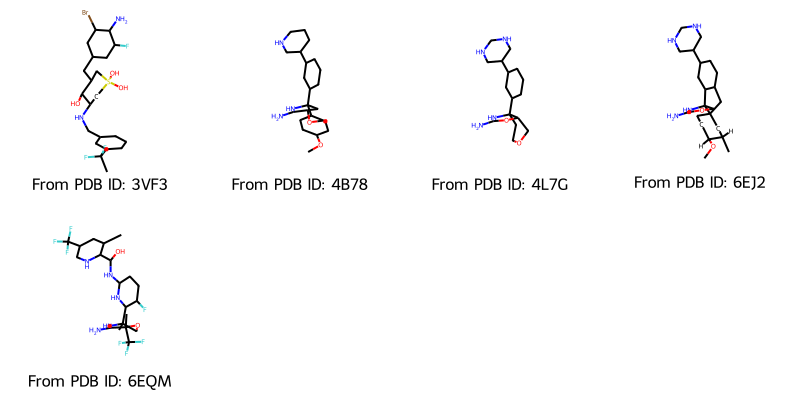

In [9]:
Draw.MolsToGridImage(
    molecules,
    molsPerRow=4,
    legends=[f"From PDB ID: {pdb_id}" for pdb_id in pdb_ids],
)

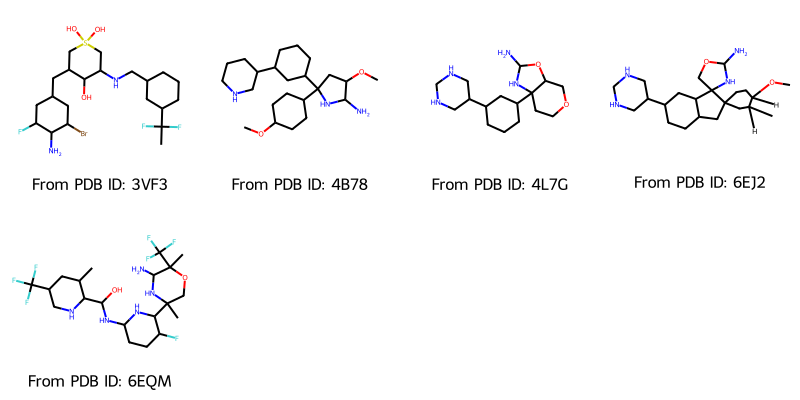

In [10]:
molecules_2d = []
for molecule in molecules:
    tmp = Chem.Mol(molecule)
    AllChem.Compute2DCoords(tmp)
    molecules_2d.append(tmp)
Draw.MolsToGridImage(
    molecules_2d,
    molsPerRow=4,
    legends=[f"From PDB ID: {pdb_id}" for pdb_id in pdb_ids],
)

#### Visualize on nglview

In [11]:
def show_ligands(molecules):
   
    view = nv.NGLWidget()
    for molecule in molecules:
        component = view.add_component(molecule)
        time.sleep(0.1)
        component.clear()
        component.add_ball_and_stick(multipleBond=True)
    return view

In [18]:
view = show_ligands(molecules)
view

NGLWidget()

In [19]:
view.render_image(trim=True, factor=2, transparent=True);

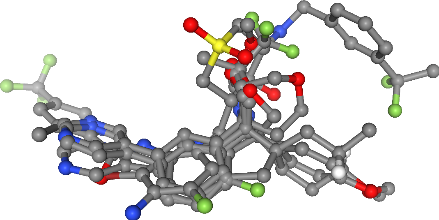

In [20]:
view._display_image()
# green = hydrogen bond donors, red = hydrogen bond accepters, purple hydrophobic contcat 

#### Extract pharmacophore features

In [30]:
feature_factory = AllChem.BuildFeatureFactory(str(Path(RDConfig.RDDataDir) /'BaseFeatures.fdef'))

In [31]:
list(feature_factory.GetFeatureDefs().keys())

['Donor.SingleAtomDonor',
 'Acceptor.SingleAtomAcceptor',
 'NegIonizable.AcidicGroup',
 'PosIonizable.BasicGroup',
 'PosIonizable.PosN',
 'PosIonizable.Imidazole',
 'PosIonizable.Guanidine',
 'ZnBinder.ZnBinder1',
 'ZnBinder.ZnBinder2',
 'ZnBinder.ZnBinder3',
 'ZnBinder.ZnBinder4',
 'ZnBinder.ZnBinder5',
 'ZnBinder.ZnBinder6',
 'Aromatic.Arom4',
 'Aromatic.Arom5',
 'Aromatic.Arom6',
 'Aromatic.Arom7',
 'Aromatic.Arom8',
 'Hydrophobe.ThreeWayAttach',
 'Hydrophobe.ChainTwoWayAttach',
 'LumpedHydrophobe.Nitro2',
 'LumpedHydrophobe.RH6_6',
 'LumpedHydrophobe.RH5_5',
 'LumpedHydrophobe.RH4_4',
 'LumpedHydrophobe.RH3_3',
 'LumpedHydrophobe.tButyl',
 'LumpedHydrophobe.iPropyl']

In [1]:
# feature extraction
molecule_feature_frequencies = []
for molecule in molecules:
    features = [feature.GetFamily() for feature in feature_factory.GetFeaturesForMol(molecule)]
    feature_frequency = collections.Counter(features)
    molecule_feature_frequencies.append(feature_frequency)

feature_frequencies_df = (
    pd.DataFrame(
        molecule_feature_frequencies,
        index=[f"Mol{i}" for i, _ in enumerate(molecules, 1)],
    )
    .fillna(0)
    .astype(int)
)
print(feature_frequencies_df.transpose())

NameError: name 'molecules' is not defined